# Predicting a frame using 4 tone CfL
In this notebook, we predict an entire frame using 4 tone CfL. This allows us to analyze the tone distribution.

# Prologue

In [1]:
%matplotlib inline

from scipy.ndimage  import imread
import matplotlib.pyplot as plt
import numpy as np

from RGB_and_YUV import conv_ycbcr
from RGB_and_YUV import conv_rgb

from cfl_utils import dc_pred
from cfl_utils import error
from cfl_utils import scale
from cfl_utils import pick_alpha
from cfl_utils import pick_alpha_pos_neg
from cfl_utils import psnr

# Load Image

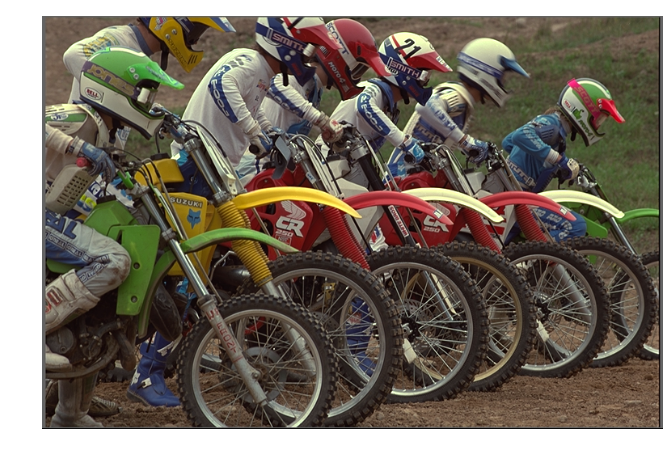

In [2]:
im = imread("images/kodim/kodim05.png")
height, width, planes = im.shape
plt.figure(figsize=(8,8))
plt.imshow(im);
plt.axis('off');

yuv = conv_ycbcr(im)
luma = yuv[:,:,0]
u = yuv[:,:,1]
v = yuv[:,:,2]
gray = np.ones((height, width)) * 127

# Parameters
We will use a block size of 16 and the magnitudes for CfL range from -2 to 2 with a step of 0.125

In [3]:
block_size = 16
mags = np.arange(-2, 2, 0.125)

# Search
for each block, we try out all alpha pairs and pick the best one.

In [4]:
a_pos_u = np.zeros((height // block_size, width // block_size))
a_neg_u = np.zeros((height // block_size, width // block_size))
a_pos_v = np.zeros((height // block_size, width // block_size))
a_neg_v = np.zeros((height // block_size, width // block_size))
a_u = np.zeros((height // block_size, width // block_size))
a_v = np.zeros((height // block_size, width // block_size))

for y in range(0, height, block_size):
    yy = y // block_size
    for x in range(0, width, block_size):
        xx = x // block_size
        block_y = luma[y:y + block_size, x:x+block_size]
        block_u = u[y:y + block_size, x:x+block_size]
        block_v = v[y:y + block_size, x:x+block_size]
        ac_con = block_y - block_y.mean()
        dc_pred_u = dc_pred(u, x, y, block_size)
        dc_pred_v = dc_pred(v, x, y, block_size)
        a_u[yy,xx], a_v[yy,xx] = pick_alpha(ac_con, mags, block_size, dc_pred_u, dc_pred_v, block_u, block_v)
        a_pos_u[yy,xx], a_neg_u[yy,xx], a_pos_v[yy,xx], a_neg_v[yy,xx] = \
        pick_alpha_pos_neg(ac_con, mags, block_size, dc_pred_u, dc_pred_v, block_u, block_v)


# Reconstruct Prediction
To validate the search we reconstruct the predicted image. Comparing PSNRs, we can see that 4 tone CfL gives about a 1 dB gain.

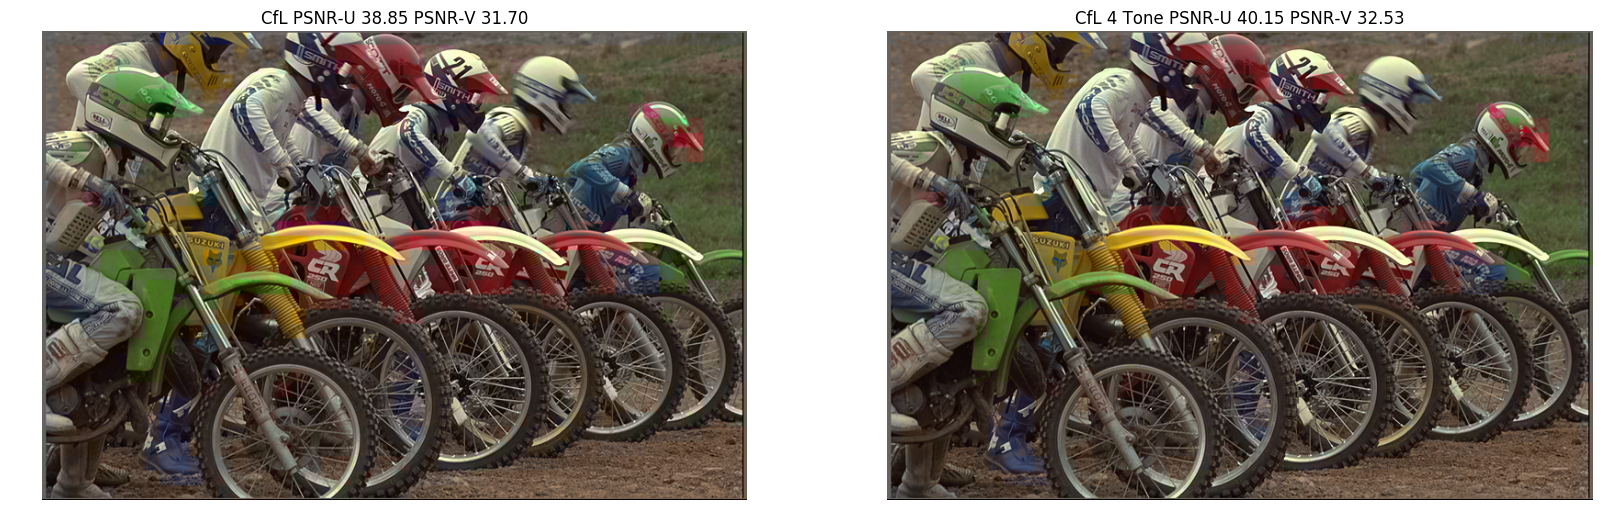

In [20]:
pred_cfl = np.zeros((height, width, 3))
pred_cfl_4t = np.zeros((height, width, 3))
for y in range(0, height, block_size):
    yy = y // block_size
    for x in range(0, width, block_size):
        xx = x // block_size
        block_y = luma[y:y + block_size, x:x+block_size]
        block_v = v[y:y + block_size, x:x+block_size]
        ac_con = block_y - block_y.mean()
        dc_pred_u = dc_pred(u, x, y, block_size)
        dc_pred_v = dc_pred(v, x, y, block_size)
        cfl_u = ac_con * a_u[yy,xx] + dc_pred_u
        cfl_v = ac_con * a_v[yy,xx] + dc_pred_v
        pred_cfl[y:y+block_size, x:x+block_size, 0] = luma[y:y + block_size, x:x+block_size]
        pred_cfl[y:y+block_size, x:x+block_size, 1] = cfl_u
        pred_cfl[y:y+block_size, x:x+block_size, 2] = cfl_v
        
        cfl4t_u = scale(ac_con, a_pos_u[yy,xx], a_neg_u[yy,xx], block_size) + dc_pred_u
        cfl4t_v = scale(ac_con, a_pos_v[yy,xx], a_neg_v[yy,xx], block_size) + dc_pred_v
        pred_cfl_4t[y:y+block_size, x:x+block_size, 0] = luma[y:y + block_size, x:x+block_size]
        pred_cfl_4t[y:y+block_size, x:x+block_size, 1] = cfl4t_u
        pred_cfl_4t[y:y+block_size, x:x+block_size, 2] = cfl4t_v

rgb_pred_cfl = conv_rgb(pred_cfl)
psnr_pred_cfl_u = psnr(im[:,:,1], rgb_pred_cfl[:,:,1])
psnr_pred_cfl_v = psnr(im[:,:,2], rgb_pred_cfl[:,:,2])

rgb_pred_cfl_4t = conv_rgb(pred_cfl_4t)
psnr_pred_cfl_4t_u = psnr(im[:,:,1], rgb_pred_cfl_4t[:,:,1])
psnr_pred_cfl_4t_v = psnr(im[:,:,2], rgb_pred_cfl_4t[:,:,2])
        
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(rgb_pred_cfl)
plt.title("CfL PSNR-U %0.2f PSNR-V %0.2f" % (psnr_pred_cfl_u, psnr_pred_cfl_v))
plt.axis('off');
plt.subplot(1,2,2)
plt.imshow(rgb_pred_cfl_4t)
plt.axis('off');
plt.title("CfL 4 Tone PSNR-U %0.2f PSNR-V %0.2f" % (psnr_pred_cfl_4t_u, psnr_pred_cfl_4t_v));

# Analysis
We are interested in the relationship between the negative and positve alphas. The following heatmap shows that only a few combinations are used most of the time.

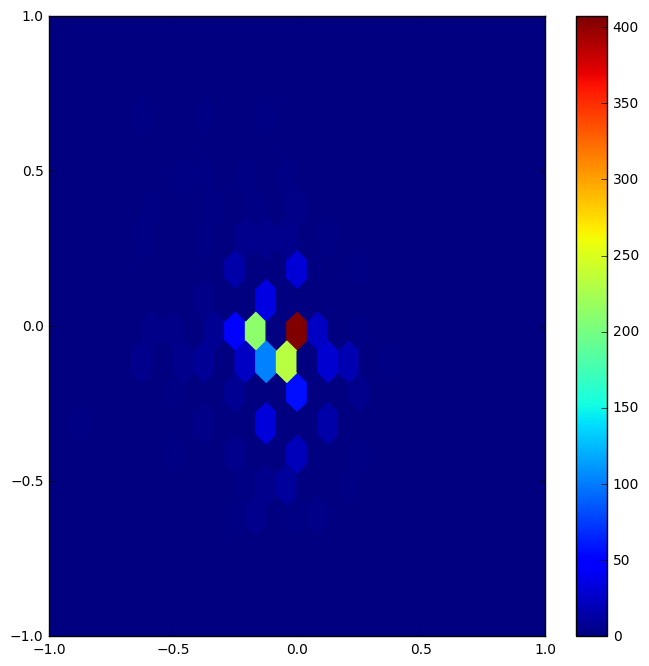

In [21]:
plt.figure(figsize=(8,8))
plt.axis([-1, 1, -1, 1])
plt.hexbin(a_pos_u.flatten(), a_neg_u.flatten(), gridsize=30)
plt.colorbar();

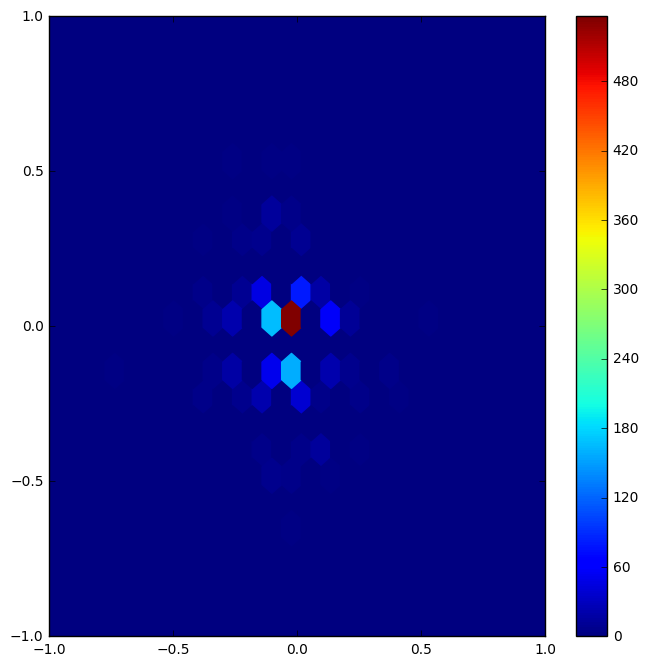

In [22]:
plt.figure(figsize=(8,8))
plt.axis([-1, 1, -1, 1])
plt.hexbin(a_pos_v.flatten(), a_neg_v.flatten(), gridsize=30)
plt.colorbar();

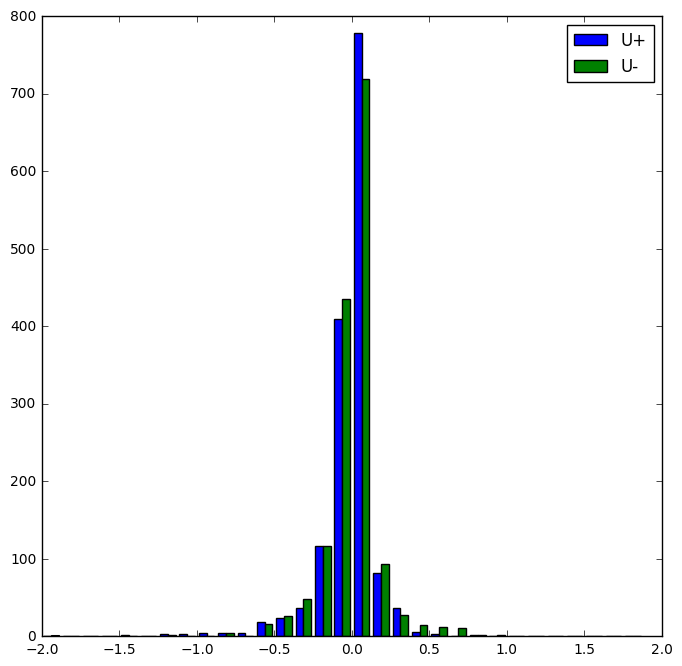

In [23]:
plt.figure(figsize=(8,8))
plt.hist([a_pos_u.flatten(), a_neg_u.flatten()], bins=mags, label=["U+", "U-"]);
plt.legend();

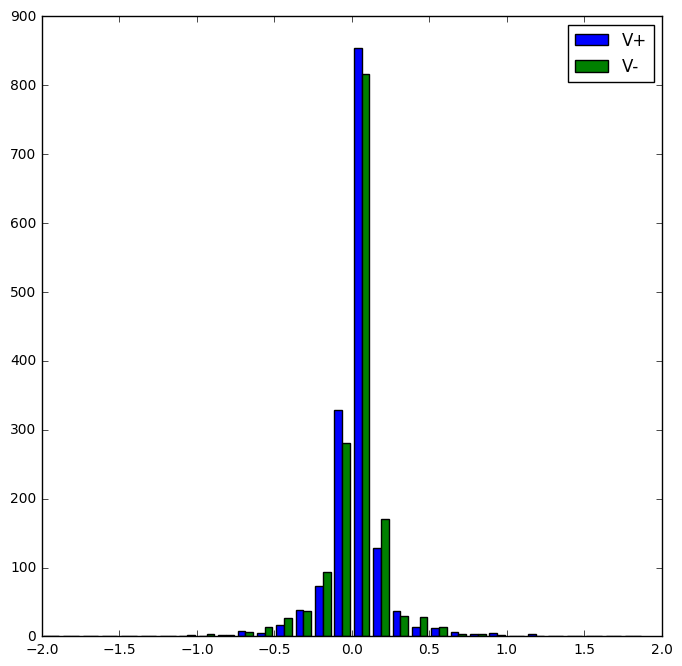

In [24]:
plt.figure(figsize=(8,8))
plt.hist([a_pos_v.flatten(), a_neg_v.flatten()], bins=mags, label=["V+", "V-"])
plt.legend();